# Carrier Home Challenge
---
This home challenge has been solved by Rohit Nigam on February 16th, 2021. 

---

This notebook is divided in 4 sections
1. Loading and Pre-processing the data
2. Building the Models
3. Conclusion
4. Predicting on the test data set.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Loading and pre processing the data
---


In [2]:
df_results = pd.DataFrame(columns=['Model', 'Train Recall Score', 'Test Recall Score'])

In [3]:
df_train = pd.read_csv('2021-01-21_zeta-disease_training-data_dsi-take-home-challenge.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 800 non-null    int64  
 1   weight              800 non-null    int64  
 2   bmi                 800 non-null    float64
 3   blood_pressure      800 non-null    int64  
 4   insulin_test        800 non-null    int64  
 5   liver_stress_test   800 non-null    float64
 6   cardio_stress_test  800 non-null    int64  
 7   years_smoking       800 non-null    int64  
 8   zeta_disease        800 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.4 KB


Good to see there are no nulls in any column!! :-)

In [5]:
df_train.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


In [6]:
X = df_train.drop('zeta_disease', axis=1)
y = df_train['zeta_disease']

In [7]:
X.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
0,54,189,27.1,80,0,1.5038,0,10
1,23,150,38.5,68,71,0.3868,55,2
2,47,186,29.9,90,0,0.2728,0,7
3,18,150,30.8,70,1033,0.6598,56,0
4,24,160,32.4,74,125,0.7608,59,2


## 1.1. Checking the Data Imbalance

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='zeta_disease', ylabel='count'>

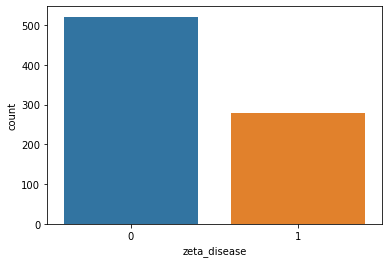

In [8]:
sns.countplot(y)

There is **data imbalance**. While creating the model, it needs to be countered.

---
## 1.2. EDA and Feature Engineering

Let us check the spread of the indicator variables.

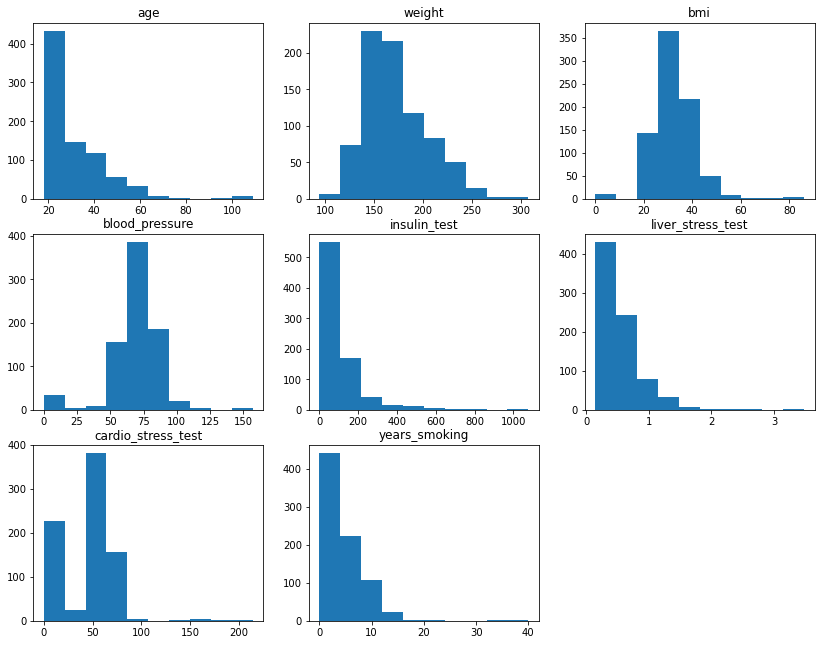

In [9]:
plt.figure(figsize=(14, 11))
for col in X.columns:
    plt.subplot(3, 3, list(X.columns).index(col)+1)
    plt.hist(X[col])
    plt.title(col)
plt.show()

In [10]:
X.skew()

age                   2.031742
weight                0.734588
bmi                   0.605968
blood_pressure       -1.357085
insulin_test          2.827382
liver_stress_test     2.330998
cardio_stress_test    0.148022
years_smoking         3.037747
dtype: float64

As we can see, the distribution of the factors - columns age, insulin_test, liver_stress_test and years_smoking are left skewed. So, I will take boxcox of them

In [11]:
cols_skewed = ['age', 'insulin_test', 'blood_pressure', 'liver_stress_test', 'years_smoking']

In [12]:
from scipy import stats

for col in cols_skewed:
    new_col = col+'_boxcox'
    X[new_col] = stats.boxcox(X[col]+1)[0] #adding 1 for a workaround for zero.

In [13]:
X_noskew = X.drop(columns=cols_skewed, axis=1)

In [14]:
X_noskew.head()

,weight,bmi,cardio_stress_test,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,189,27.1,0,0.929200,0.000000,328.583216,0.379492,2.617001
1,150,38.5,55,0.910260,4.370475,262.586943,0.229099,1.143165
2,186,29.9,0,0.927113,0.000000,386.641187,0.184683,2.242928
3,150,30.8,56,0.901157,7.190557,273.293337,0.297846,0.000000
4,160,32.4,59,0.911632,4.956476,295.063446,0.314862,1.143165


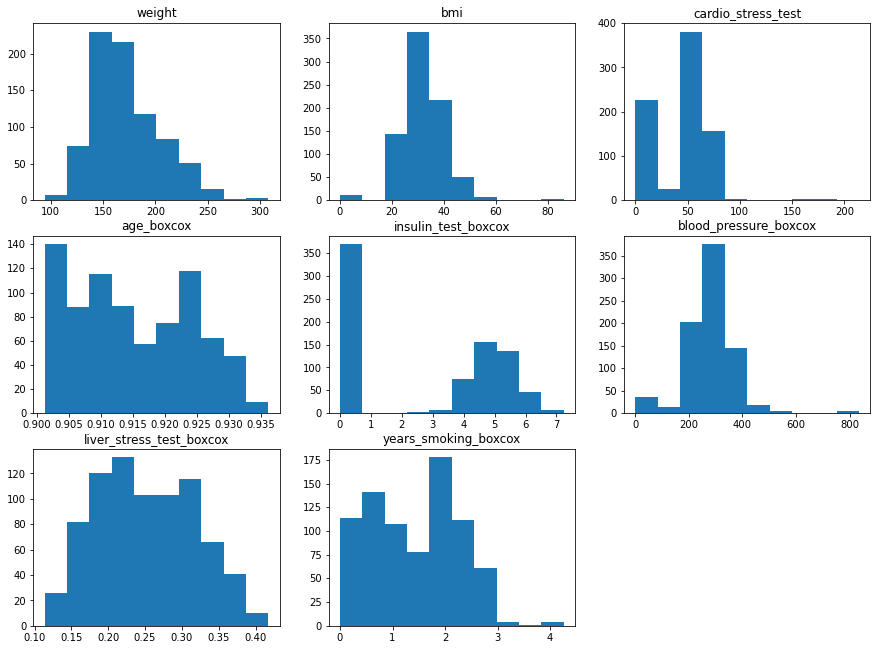

In [15]:
plt.figure(figsize=(15, 15))
for col in X_noskew.columns:
    plt.subplot(4, 3, list(X_noskew.columns).index(col)+1)
    plt.hist(X_noskew[col])
    plt.title(col)
plt.show()

In [16]:
X_noskew.skew()

weight                      0.734588
bmi                         0.605968
cardio_stress_test          0.148022
age_boxcox                  0.150629
insulin_test_boxcox        -0.015211
blood_pressure_boxcox      -0.026759
liver_stress_test_boxcox    0.143965
years_smoking_boxcox       -0.012509
dtype: float64

The skewness scores and the distributions look much better now

Let's check the spread and the outliers.

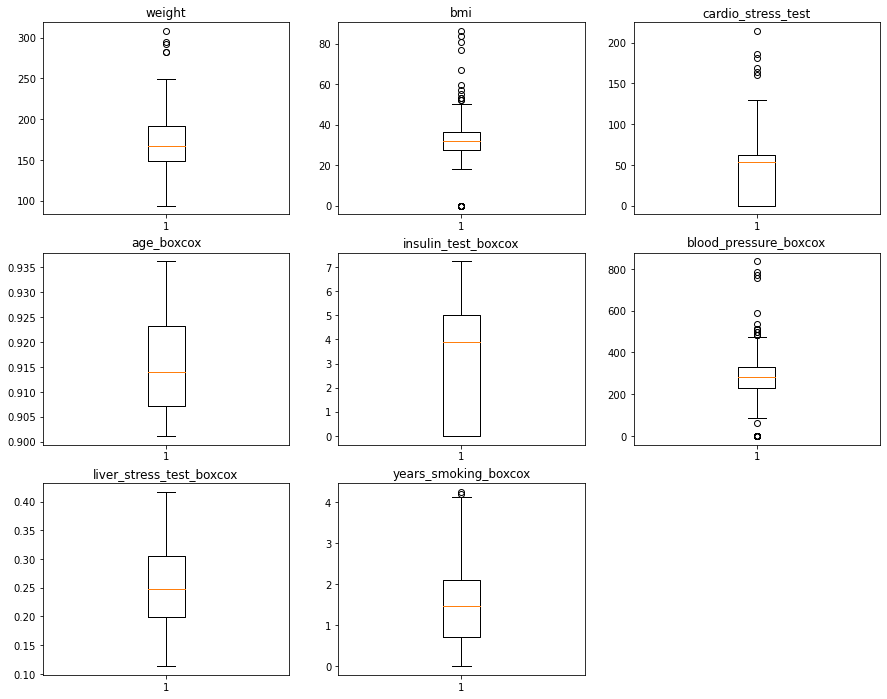

In [17]:
plt.figure(figsize=(15, 12))
for col in X_noskew.columns:
    plt.subplot(3, 3, list(X_noskew.columns).index(col)+1)
    plt.boxplot(X_noskew[col])
    plt.title(col)
plt.show()

Checking the correlations

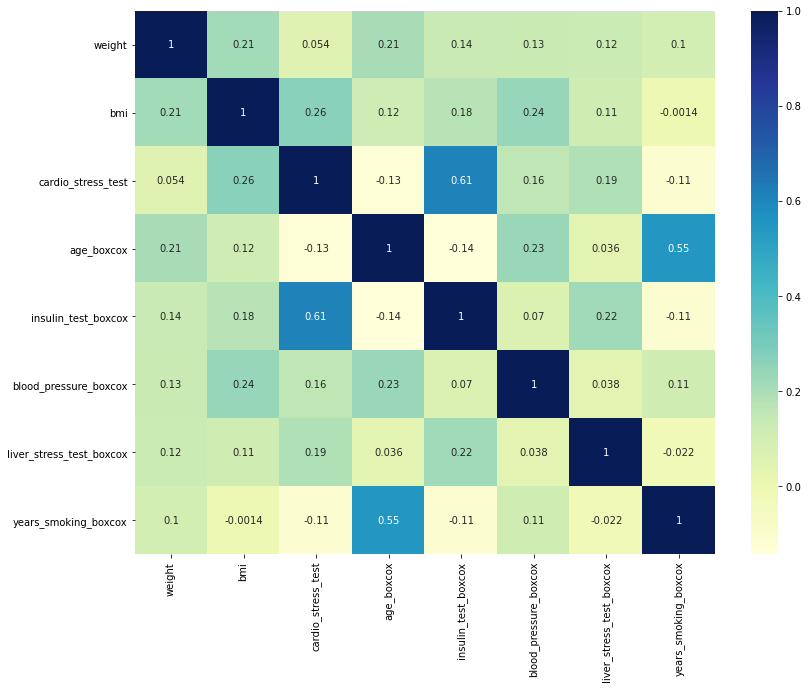

In [18]:
plt.figure(figsize=(13, 10))
sns.heatmap(X_noskew.corr(), annot=True, cmap="YlGnBu")
plt.show()

There are two strong correlations which can be seen
1. The Age is related with the number of years one has smoked. As the age increases a smoker's number of years also increases.
2. The Insulin test and the Cardio stress test are also correlated, although not very strongly.
---

## 1.3. Doing the train test split and scaling the data

Time to do the train test split in the training test. As there are 800 cases, a 70:30 split will be appropriate

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_noskew, y, test_size=0.3, random_state=10)

As there are outliers, standard scaling will be prefered as the outliers don't impact it much

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [21]:
cols_X = X_train.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_train_scaled.columns = cols_X
X_train_scaled.head()

,weight,bmi,cardio_stress_test,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,1.785039,0.569672,0.435974,0.537589,0.778921,1.192382,-0.389522,-1.616452
1,0.251781,-1.099479,0.049056,-1.449223,1.407133,-0.413155,-0.030695,-0.787198
2,-0.436621,0.478391,0.919621,-0.626903,0.925485,-0.527503,0.447052,0.614799
3,-0.467912,-0.903875,0.629432,-1.449223,0.587491,-0.527503,-1.630501,-0.282610
4,-0.374039,0.647914,4.079450,1.553050,1.119427,0.057970,1.896692,0.374398


In [22]:
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))
X_test_scaled.columns = cols_X
X_test_scaled.head()

,weight,bmi,cardio_stress_test,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,0.467465,-3.142603,-1.547808,1.669674,-1.110721,0.606378,0.840220,0.481279
1,-0.664513,0.789848,1.296609,-0.786767,0.569500,-0.027414,0.931911,-0.391248
2,-0.507293,0.246102,0.880353,-0.786767,0.778425,-0.620133,-0.879095,-0.391248
3,-1.513495,-1.093844,-1.547808,-0.786767,-1.110721,-2.624802,-0.220362,-1.688108
4,-0.947507,-0.792842,-1.547808,1.425581,-1.110721,-0.129168,-1.046888,1.152711


# 2. Building the Models
---
## 2.1. Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [24]:
mod_log = LogisticRegression(class_weight="balanced").fit(X_train_scaled, y_train)

<AxesSubplot:>

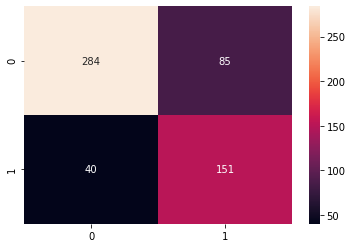

In [25]:
#Plotting the confusion matrix
sns.heatmap(metrics.confusion_matrix(y_train, mod_log.predict(X_train_scaled)), annot=True, fmt='g')

In [27]:
df_results.loc[len(df_results)] = ['Balanced Log Regression', 
                                   metrics.recall_score(y_train, mod_log.predict(X_train_scaled)), 
                                   metrics.recall_score(y_test,  mod_log.predict(X_test_scaled))]

In [28]:
df_results

,Model,Train Recall Score,Test Recall Score
0,Balanced Log Regression,0.790576,0.659091
1,Balanced Log Regression,0.790576,0.659091


---

## 2.2. Random Forests.

### 2.2.1 Default Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
default_rf_model = RandomForestClassifier(class_weight="balanced").fit(X_train_scaled, y_train)

In [30]:
df_results.loc[len(df_results)] = ['Default Random Forest', 
                                   metrics.recall_score(y_train, default_rf_model.predict(X_train_scaled)), 
                                   metrics.recall_score(y_test,  default_rf_model.predict(X_test_scaled))]
df_results

,Model,Train Recall Score,Test Recall Score
0,Balanced Log Regression,0.790576,0.659091
1,Balanced Log Regression,0.790576,0.659091
2,Default Random Forest,1.000000,0.556818


### 2.2.2. Tuned Random Forests

Clearly, the Random Forest is heavily overfitted. With more cross folding and more tuning, a better result can be achieved in the Random Forests.

In [31]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_folds = 10

As it is more important to predict the True values, the focus will stay on the Recalls.
Also, because there already is cross folding, the train and test set will not be used, instead the whole set will be used

In [32]:
X_scaled = pd.DataFrame(scaler.fit_transform(X_noskew))
X_scaled.columns = cols_X
X_scaled.head()

,weight,bmi,cardio_stress_test,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,0.519775,-0.597114,-1.418885,1.521708,-1.053140,0.531278,1.940210,1.387065
1,-0.701935,0.737186,0.390865,-0.512649,0.676294,-0.162840,-0.329453,-0.315353
2,0.425797,-0.269391,-1.418885,1.297592,-1.053140,1.141905,-0.999767,0.954976
3,-0.701935,-0.164052,0.423769,-1.490501,1.792224,-0.050236,0.708034,-1.635816
4,-0.388676,0.023219,0.522483,-0.365292,0.908179,0.178732,0.964833,-0.315353


In [33]:
parameters = {'max_depth': range(3, 10, 1)}

rf1 = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

rf1 = GridSearchCV(rf1, parameters, 
                    cv=n_folds, 
                   scoring="recall",
                 return_train_score=True)
rf1.fit(X_scaled, y)
scores = rf1.cv_results_

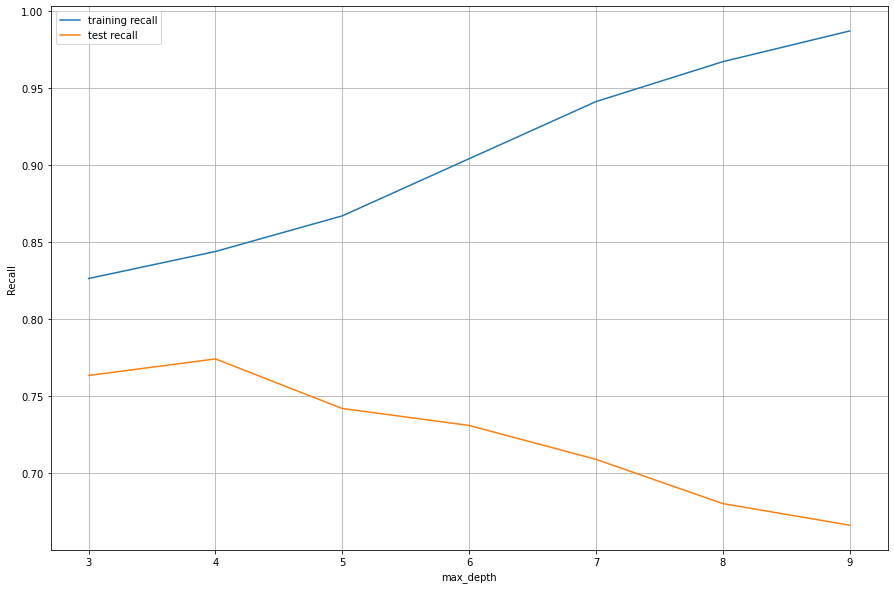

In [34]:
plt.figure(figsize=(15, 10))
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.legend()
plt.grid()
plt.show()

The depth as 4 looks to be appropriate

In [35]:
df_results.loc[len(df_results)] = ['Random Forest 1', 
                                   metrics.recall_score(y_train, rf1.best_estimator_.predict(X_train_scaled)), 
                                   metrics.recall_score(y_test,  rf1.best_estimator_.predict(X_test_scaled))]
df_results

,Model,Train Recall Score,Test Recall Score
0,Balanced Log Regression,0.790576,0.659091
1,Balanced Log Regression,0.790576,0.659091
2,Default Random Forest,1.000000,0.556818
3,Random Forest 1,0.790576,0.840909


In [36]:
parameters = {'n_estimators': range(10, 80, 2)}
rf2 = RandomForestClassifier(max_depth=4, class_weight='balanced', n_jobs=-1)
rf2 = GridSearchCV(rf2, parameters, 
                    cv=n_folds, 
                   scoring="recall",
                 return_train_score=True)
rf2.fit(X_scaled, y)
scores = rf2.cv_results_

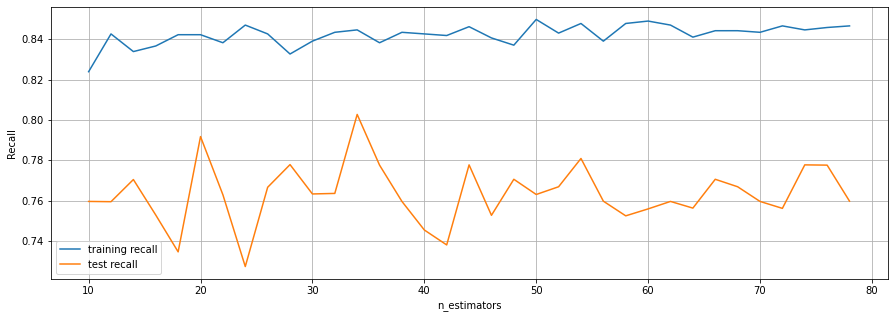

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.grid()
plt.legend()
plt.show()

In [38]:
pd.DataFrame(scores).sort_values(by='mean_test_score', ascending=False).head(1)[['mean_test_score', 'params']]

,mean_test_score,params
12,0.802778,{'n_estimators': 34}


The number of estimators as 48 is the best with the mean test score of 78.85%

In [39]:
df_results.loc[len(df_results)] = ['Random Forest 2', 
                                   metrics.recall_score(y_train, rf2.best_estimator_.predict(X_train_scaled)), 
                                   metrics.recall_score(y_test,  rf2.best_estimator_.predict(X_test_scaled))]
df_results

,Model,Train Recall Score,Test Recall Score
0,Balanced Log Regression,0.790576,0.659091
1,Balanced Log Regression,0.790576,0.659091
2,Default Random Forest,1.000000,0.556818
3,Random Forest 1,0.790576,0.840909
4,Random Forest 2,0.806283,0.818182


In [40]:
parameters = {'max_features': range(1, 9)}
rf3 = RandomForestClassifier(max_depth=4, n_estimators=48, class_weight='balanced', n_jobs=-1)
rf3 = GridSearchCV(rf3, parameters, 
                    cv=n_folds, 
                   scoring="recall",
                 return_train_score=True)
rf3.fit(X_train_scaled, y_train)
scores = rf3.cv_results_

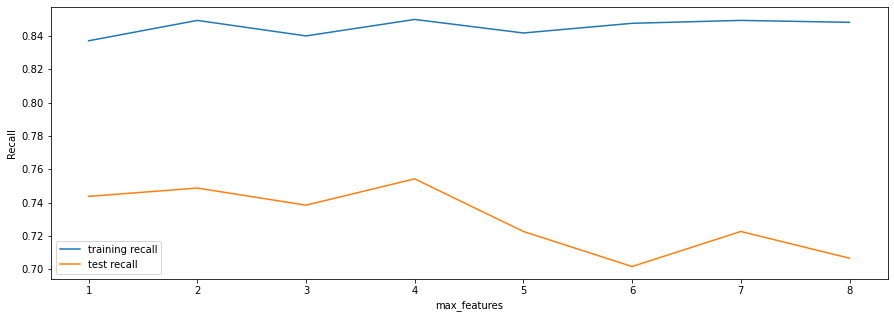

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_features")
plt.ylabel("Recall")
plt.legend()
plt.show()

In [42]:
pd.DataFrame(scores).sort_values(by='mean_test_score', ascending=False)[['params', 'mean_train_score', 'mean_test_score']].head()

,params,mean_train_score,mean_test_score
3,{'max_features': 4},0.849908,0.754211
1,{'max_features': 2},0.849334,0.748684
0,{'max_features': 1},0.837107,0.743684
2,{'max_features': 3},0.840024,0.738421
4,{'max_features': 5},0.841782,0.722632


So, we can have a decent recall score of 73.32% with 4 features.

In [43]:
df_results.loc[len(df_results)] = ['Random Forest 3', 
                                   metrics.recall_score(y_train, rf3.best_estimator_.predict(X_train_scaled)), 
                                   metrics.recall_score(y_test,  rf3.best_estimator_.predict(X_test_scaled))]
df_results

,Model,Train Recall Score,Test Recall Score
0,Balanced Log Regression,0.790576,0.659091
1,Balanced Log Regression,0.790576,0.659091
2,Default Random Forest,1.000000,0.556818
3,Random Forest 1,0.790576,0.840909
4,Random Forest 2,0.806283,0.818182
5,Random Forest 3,0.832461,0.727273


In [44]:
parameters = {'min_samples_leaf': range(1, 41)}
rf4 = RandomForestClassifier(max_depth=4, n_estimators=48, max_features=4, n_jobs=-1)
rf4 = GridSearchCV(rf4, parameters, 
                    cv=n_folds, 
                   scoring="recall",
                 return_train_score=True)
rf4.fit(X_train_scaled, y_train)
scores = rf4.cv_results_

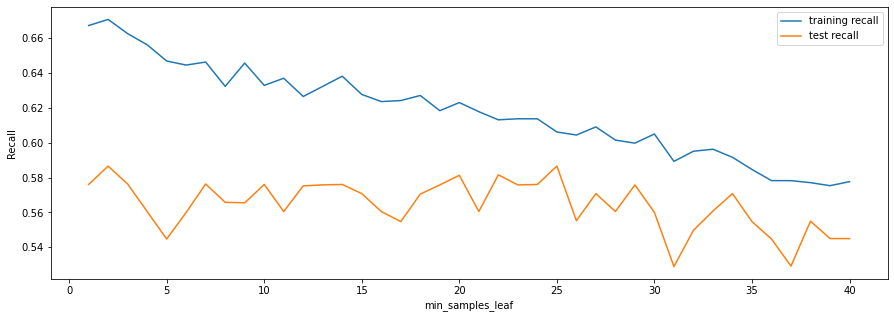

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.legend()
plt.show()

In [286]:
pd.DataFrame(scores).sort_values(by='mean_test_score', ascending=False).head(1)[['mean_test_score', 'params']]

,mean_test_score,params
13,0.607632,{'min_samples_leaf': 14}


Again, the best recall of 60.77% is achieved with the min_samples_leaf as 14. 

In [287]:
df_results.loc[len(df_results)] = ['Random Forest 4', 
                                   metrics.recall_score(y_train, rf4.best_estimator_.predict(X_train_scaled)), 
                                   metrics.recall_score(y_test,  rf4.best_estimator_.predict(X_test_scaled))]
df_results

,Model,Train Recall Score,Test Recall Score
0,Balanced Log Regression,0.790576,0.659091
1,Default Random Forest,1.000000,0.568182
2,Random Forest 1,0.801047,0.840909
3,Random Forest 2,0.790576,0.818182
4,Random Forest 3,0.900524,0.750000
5,Random Forest 4,0.654450,0.500000


---
## 2.3. Zeroing to best model and model analysis

We have hit the maximum recall with the RF1 model. Let us look at the details of this model now

In [46]:
best_model = rf1.best_estimator_

In [47]:
best_model.fit(X_scaled, y)

RandomForestClassifier(class_weight='balanced', max_depth=4, n_jobs=-1)

In [48]:
print ('The recall score of the best model is ',
       round(100*metrics.recall_score(y_test, best_model.predict(X_test_scaled)), 2),
       '%')

The recall score of the best model is  85.23 %


In [49]:
df_feature_importance = pd.DataFrame(columns=['Feature', 'Importance'])
df_feature_importance.Feature = X_scaled.columns
df_feature_importance.Importance = best_model.feature_importances_
df_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
df_feature_importance

,Feature,Importance
0,weight,0.343452
1,bmi,0.185236
3,age_boxcox,0.174962
7,years_smoking_boxcox,0.078880
6,liver_stress_test_boxcox,0.077651
4,insulin_test_boxcox,0.066634
2,cardio_stress_test,0.040331
5,blood_pressure_boxcox,0.032855


Text(0, 0.5, 'Feature')

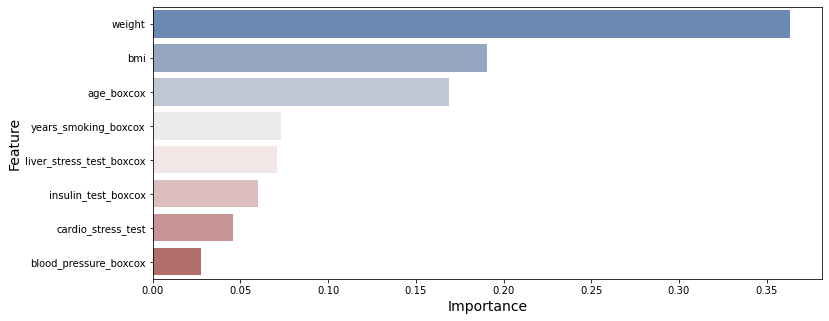

In [293]:
plt.figure(figsize=(12, 5))
sns.barplot(x='Importance', y='Feature', data=df_feature_importance, palette='vlag')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# 3. Conculsion from the model:

The metrics that has been used in the model building is **recall**. The problem statment says we need to make the correct prediction in the cases who will be infected from the disease. 

The forumla for recall is given as $\frac{True Positive}{True Positive + False Negative}$ and hence having a high recall value ensures that there are lease False Negatives. Hence the model will be able to catch more of the infection possibilities

The three risk factors which have the hightest impact are **weight**, **bmi** and the **age**. Hence people who have are older and have a higher weight and bmi should be more cautious in the International Mars Colony as they have the highest chances of zeta infection

---
# 4. Predicting from the Test data
---
## 4.1. Doing the same data transformations as done on the Training data set

In [235]:
df_test = pd.read_csv('2021-01-21_zeta-disease_prediction-data_dsi-take-home-challenge.csv')
df_test.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,NaN
1,27,179,35.5,89,156,1.6608,43,6,NaN
2,34,147,26.9,76,74,1.6958,53,2,NaN
3,35,206,32.4,73,127,1.4608,61,6,NaN
4,60,193,29.8,62,192,1.7798,65,9,NaN


In [237]:
# Applying boxcox on the skewed data 
for col in cols_skewed:
    new_col = col+'_boxcox'
    df_test[new_col] = stats.boxcox(df_test[col]+1)[0] #adding 1 for a workaround for zero.
df_test.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,24,151,39.5,69,72,1.3968,56,4,NaN,3.470650,4.195325,0.940059,0.345031,1.380107
1,27,179,35.5,89,156,1.6608,43,6,NaN,3.602503,4.924471,0.942594,0.354462,1.617554
2,34,147,26.9,76,74,1.6958,53,2,NaN,3.864148,4.221161,0.941100,0.355471,0.988286
3,35,206,32.4,73,127,1.4608,61,6,NaN,3.897372,4.730599,0.940679,0.347656,1.617554
4,60,193,29.8,62,192,1.7798,65,9,NaN,4.527369,5.120038,0.938781,0.357711,1.852717


In [238]:
df_test.drop(cols_skewed, axis=1, inplace=True)

In [239]:
df_test.head()

,weight,bmi,cardio_stress_test,zeta_disease,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,151,39.5,56,NaN,3.470650,4.195325,0.940059,0.345031,1.380107
1,179,35.5,43,NaN,3.602503,4.924471,0.942594,0.354462,1.617554
2,147,26.9,53,NaN,3.864148,4.221161,0.941100,0.355471,0.988286
3,206,32.4,61,NaN,3.897372,4.730599,0.940679,0.347656,1.617554
4,193,29.8,65,NaN,4.527369,5.120038,0.938781,0.357711,1.852717


In [240]:
X_asked = df_test.drop('zeta_disease', axis=1)
X_asked.head()

,weight,bmi,cardio_stress_test,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,151,39.5,56,3.470650,4.195325,0.940059,0.345031,1.380107
1,179,35.5,43,3.602503,4.924471,0.942594,0.354462,1.617554
2,147,26.9,53,3.864148,4.221161,0.941100,0.355471,0.988286
3,206,32.4,61,3.897372,4.730599,0.940679,0.347656,1.617554
4,193,29.8,65,4.527369,5.120038,0.938781,0.357711,1.852717


In [242]:
X_asked_scaled = pd.DataFrame(scaler.transform(X_asked))
X_asked_scaled.columns = cols_X
X_asked_scaled.head()

,weight,bmi,cardio_stress_test,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,-0.670609,0.854230,0.423769,274.508809,0.606986,-2.914722,1.420138,-0.041663
1,0.206516,0.386054,-0.003990,288.671656,0.895515,-2.914695,1.562466,0.232610
2,-0.795913,-0.620522,0.325056,316.775999,0.617209,-2.914711,1.577697,-0.494253
3,1.052315,0.023219,0.588292,320.344698,0.818798,-2.914715,1.459755,0.232610
4,0.645079,-0.281095,0.719910,388.015103,0.972902,-2.914735,1.611491,0.504246


In [294]:
df_test.zeta_disease = best_model.predict(X_asked_scaled)

# 4.2. The final test data sets, along with the predictions

In [295]:
df_test

,weight,bmi,cardio_stress_test,zeta_disease,age_boxcox,insulin_test_boxcox,blood_pressure_boxcox,liver_stress_test_boxcox,years_smoking_boxcox
0,151,39.5,56,0,3.470650,4.195325,0.940059,0.345031,1.380107
1,179,35.5,43,1,3.602503,4.924471,0.942594,0.354462,1.617554
2,147,26.9,53,0,3.864148,4.221161,0.941100,0.355471,0.988286
3,206,32.4,61,1,3.897372,4.730599,0.940679,0.347656,1.617554
4,193,29.8,65,1,4.527369,5.120038,0.938781,0.357711,1.852717
5,120,36.5,54,0,4.188295,3.851832,0.944122,0.340436,2.015493
6,139,38.2,68,0,3.269141,4.258637,0.938574,0.351999,1.213767
7,137,31.2,59,0,3.423324,4.208331,0.940221,0.345878,1.707526
8,195,30.5,59,1,3.929727,4.829191,0.938139,0.347223,1.617554
9,193,25.8,50,0,3.213042,4.113297,0.942075,0.358061,1.213767
